### Import Dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#CONSTS
READ_FOLDER_PATH = '../data/processed/'
WRITE_FOLDER_PATH = '../data/processed/'

aggregated_data = pd.read_csv(READ_FOLDER_PATH+'aggregated_data.csv')

print(aggregated_data.shape[0])
pd.set_option("display.max_colwidth", None) 

9074


### Initial Random Forest Model Train and Test

- Random Forest Model (with class weighting to handle inbalance: 76% 1's and 24% 0's)
- Evaluate the model with feature importance display

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

data = aggregated_data.copy()

# Feature columns to select
feature_columns = [
    # 'home_shots_pre80', 'away_shots_pre80', 'home_fouls_pre80', 'away_fouls_pre80',
    # 'home_corners_pre80', 'away_corners_pre80', 'home_yellow_cards_pre80', 'away_yellow_cards_pre80',
    # 'home_sending_off_pre80', 'away_sending_off_pre80', 
    # 'goal_diff_80',
    'home_corners_70_75', 'away_corners_70_75', 'home_shots_70_75', 'away_shots_70_75',
    'home_corners_75_80', 'away_corners_75_80', 'home_shots_75_80', 'away_shots_75_80',
    # 'home_fouls_70_75', 'away_fouls_70_75', 'home_fouls_70_75', 'away_fouls_70_75',
]

features = data[feature_columns].copy()  
features = features.apply(pd.to_numeric, errors='coerce') #ensure data is numericc
features.dropna(inplace=True)
 
target = data.loc[features.index, 'target'] 

# Split data -> train & test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2,random_state=42, stratify=target)

#Train our Random Forest model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100,class_weight="balanced")
rf_model.fit(X_train, y_train)

#Make predictions on test set
y_pred = rf_model.predict(X_test)

# --- Model Evaluation ---
#confusion matrix:
print("### Classification Report:\n") 
print(classification_report(y_test, y_pred))  

#feature importance:
feature_importances = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\n### Feature Importance:\n") 
print(feature_importances.to_string(index=False)) 
 

### Classification Report:

              precision    recall  f1-score   support

           0       0.23      0.43      0.30       435
           1       0.76      0.56      0.64      1380

    accuracy                           0.53      1815
   macro avg       0.49      0.49      0.47      1815
weighted avg       0.63      0.53      0.56      1815


### Feature Importance:

           Feature  Importance
  home_shots_70_75    0.176405
  home_shots_75_80    0.166005
  away_shots_70_75    0.159255
  away_shots_75_80    0.123542
home_corners_75_80    0.103982
home_corners_70_75    0.094886
away_corners_70_75    0.090211
away_corners_75_80    0.085713


### Precision-Recall Optimization via Threshold Adjustment

- Our aim is to increase Precision-Recall (more importantly precision), since we want to increase the likelihood of winning a 1+ corners at 80min bet -> prediciting the number of 1's correctly as important, i.e. when we do place a bet, we make sure we have a high chance of winning.
- Therefore, I performed threshold adjustament to try and maximise precision.

In [3]:
from sklearn.metrics import precision_score, recall_score, classification_report

# # Get probability predictions
y_probs = rf_model.predict_proba(X_test)[:, 1]  # Probability of class 1 (corner)

#USe threshold of 0.7 to increase precision of target=1:
threshold=0.7
y_pred_threshold =(y_probs >= threshold).astype(int)

#Evaluate precision and recall
precision =precision_score(y_test, y_pred_threshold)
recall = recall_score(y_test, y_pred_threshold)

print(f"Threshold: {threshold}") 
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("\n### Classification Report:\n") 
print(classification_report(y_test, y_pred_threshold))

#--- Threshold Maximisation ---
thresholds = np.linspace(0.5, 0.9, 5) #test thresholds from 0.5 to 0.9
results = []   
for t in thresholds:
    y_pred_t =(y_probs>=t).astype(int)
    precision_t= precision_score(y_test, y_pred_t)  
    recall_t= recall_score(y_test, y_pred_t)
    results.append((t, precision_t,recall_t))  
 
#results as table
print("\n### Precision-Recall Tradeoff at Different Thresholds ###\n") 
print(f"{'Threshold':<12}{'Precision':<12}{'Recall':<12}") 
print("-"*36)  
for t, p, r in results:
    print(f"{t:<12.2f}{p:<12.4f}{r:<12.4f}")

##best threshold
best_threshold = max(results, key=lambda x: x[1])
print("\n### Recommended Threshold for Maximum Precision ###")
print(f"Optimal Threshold: {best_threshold[0]:.2f}")
print(f"Expected Precision: {best_threshold[1]:.4f}")
print(f"Expected Recall: {best_threshold[2]:.4f}")
 

Threshold: 0.7
Precision: 0.7585
Recall: 0.2094

### Classification Report:

              precision    recall  f1-score   support

           0       0.24      0.79      0.37       435
           1       0.76      0.21      0.33      1380

    accuracy                           0.35      1815
   macro avg       0.50      0.50      0.35      1815
weighted avg       0.63      0.35      0.34      1815


### Precision-Recall Tradeoff at Different Thresholds ###

Threshold   Precision   Recall      
------------------------------------
0.50        0.7559      0.5609      
0.60        0.7672      0.2986      
0.70        0.7585      0.2094      
0.80        0.8057      0.1442      
0.90        0.8121      0.0971      

### Recommended Threshold for Maximum Precision ###
Optimal Threshold: 0.90
Expected Precision: 0.8121
Expected Recall: 0.0971


### RF Regressor Test

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

#target is now corner_diff (between 80min and ft)
data['corner_diff'] = data['home_corner_diff'] + data['away_corner_diff']
target_column = "corner_diff"

X = data[feature_columns]
y = data[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Train Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_test)

#Evaluate:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print("\n### Model Performance ###")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


### Model Performance ###
Mean Absolute Error (MAE): 1.0659
Mean Squared Error (MSE): 1.7849
Root Mean Squared Error (RMSE): 1.3360


### Training RF Classifier for backtesting

1) Trains RF classifier using 80-20 split to show accuracy
2) Perfroms threshold optimsation
3) Only take last 500 rows (since it needs to be unseen for backtesting simulation) and retrain model on full dataset
4) Predict & evaluate model on these 500 rows
5) Plot scatter graph to show predictions & threshold


### Optimal Threshold Found: 0.90 ###
Expected Precision: 0.8121
Expected Recall: 0.0971

### Prediction on last 500 rows: ###
              precision    recall  f1-score   support

           0       0.23      0.91      0.37       118
           1       0.72      0.08      0.14       382

    accuracy                           0.27       500
   macro avg       0.48      0.49      0.25       500
weighted avg       0.61      0.27      0.19       500



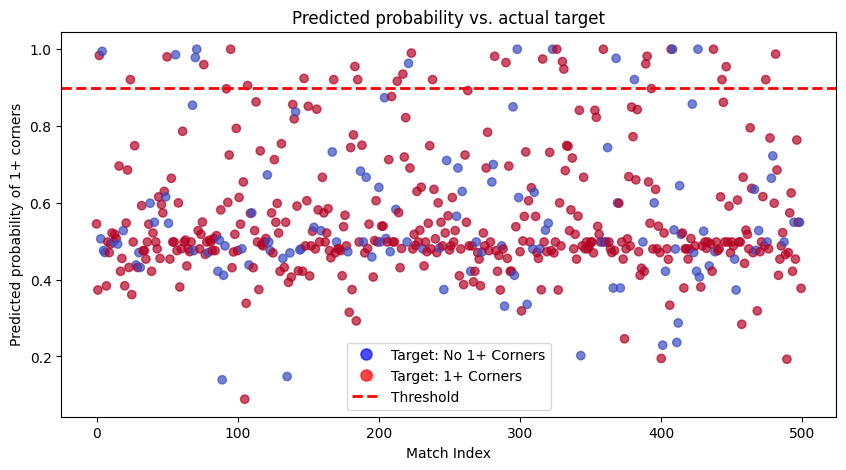

In [5]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score

data = aggregated_data.copy()

features=data[feature_columns]
target = data.loc[features.index, 'target']

# --- STEP 1: TRAIN-TEST SPLIT (80%) ---
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

rf_model =RandomForestClassifier(random_state=42, n_estimators=100,class_weight="balanced") #uses balance for uneven classes
rf_model.fit(X_train, y_train)
y_probs =rf_model.predict_proba(X_test)[:, 1] #Predicts probabillity based on mean of RF trees

#--- Threshold Maximisation ---
thresholds = np.linspace(0.5, 0.9, 5) #test thresholds from 0.5 to 0.9
results = []   
for t in thresholds:
    y_pred_t =(y_probs>=t).astype(int)
    precision_t= precision_score(y_test, y_pred_t)  
    recall_t= recall_score(y_test, y_pred_t)
    results.append((t, precision_t,recall_t))  

##best threshold
best_threshold = max(results, key=lambda x: x[1])
optimal_threshold = best_threshold[0]
print(f"\n### Optimal Threshold Found: {optimal_threshold:.2f} ###")
print(f"Expected Precision: {best_threshold[1]:.4f}")
print(f"Expected Recall: {best_threshold[2]:.4f}")

# --- STEP 2: RETRAIN ON FULL DATASET (EXCEPT LAST 500 ROWS) ---
train_data = data.iloc[:-500]
features_train_set=train_data[feature_columns]
target_train_set=train_data.loc[features_train_set.index, 'target']

final_rf_model =RandomForestClassifier(random_state=42, n_estimators=100, class_weight="balanced")
final_rf_model.fit(features_train_set, target_train_set)

# --- STEP 3: TEST ON LAST 500 ROWS ---
test_data = data.iloc[-500:] #get last 500 rows
features_test_set = test_data[feature_columns]
target_test_set =test_data.loc[features_test_set.index, 'target']

#Do prediction on these last rows
y_probs_final= final_rf_model.predict_proba(features_test_set)[:, 1]
y_pred_final= (y_probs_final>=optimal_threshold).astype(int)

#Evaluate on the last 500 rows (final simulation)
print("\n### Prediction on last 500 rows: ###")
print(classification_report(target_test_set, y_pred_final))

# Scatter plot: target vs predicted probabilities
plt.figure(figsize=(10, 5))
plt.scatter(range(len(y_probs_final)), y_probs_final,c=target_test_set,cmap='coolwarm',alpha=0.7,label='Predicted Probability')
plt.axhline(optimal_threshold, color='red', linestyle='dashed',linewidth=2,label=f'Threshold = {optimal_threshold:.2f}')
import matplotlib.lines as mlines
class_0 =mlines.Line2D([], [],color='blue',marker='o',linestyle='None', markersize=8, alpha=0.7, label='Target: No 1+ Corners')
class_1=mlines.Line2D([], [],color='red', marker='o',linestyle='None',markersize=8,alpha=0.7, label='Target: 1+ Corners')
plt.xlabel('Match Index')
plt.ylabel('Predicted probability of 1+ corners')
plt.title('Predicted probability vs. actual target')
plt.legend(handles=[class_0, class_1,plt.Line2D([], [],color='red',linestyle='dashed',linewidth=2,label='Threshold')])
plt.show()


### Feed data into CSV to be used for simulation
- Saves a csv with match_id, odds, model predictions, and actual results

In [6]:
results_df = pd.DataFrame({
    'kaggle_id': test_data['id_odsp'],
    'model_predicted_binary': y_pred_final,
    'actual_result': target_test_set
})
data_file = "../classification_predictions.csv"
results_df.to_csv(data_file, index=False)
print(f"Results saved to {data_file}")

Results saved to ../classification_predictions.csv
